In [16]:
Threads.nthreads()

1

# Radar System Simulation

In [17]:
using Plots
using DSP
using FFTW

In [18]:
include("radarsim.jl")
using .radarsim;

### System Constants

In [19]:
samp_rate = 5e6  #hz
prf = 100 #Hz
duty_factor = .15; #.05
β = 1e6; #Pulse Bandwidth
repetitions = 128;
fc = 900_000_000; #Hz

Gt = 40; #dB
Gr = 45; #dB
system_loss = 6; #dB
coefficients = [1,14,8];

targets = [Target(560_094, 0)]
num_targets = length(targets);

In [20]:
τ = duty_factor * (1/prf);
λ = (1/fc) * c;

### Min and Max theoretical range

In [21]:

println("Maximum Range (km): ", (1/prf * c / 2) / 1000)
println("Minimum Range (km): ", (τ * c / 2) / 1000)


Maximum Range (km): 1498.96229
Minimum Range (km): 224.8443435


### Simulation

In [27]:
t, pulse_train = gen_pulse_train(repetitions, samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="Increasing", coefficients);

MethodError: MethodError: no method matching gen_pulse_train(::Int64, ::Float64, ::Int64, ::Float64, ::Float64, ::Vector{Int64}; envelope_type="Rectangular", pulse_type="Increasing")
Closest candidates are:
  gen_pulse_train(::Any, ::Any, ::Any, ::Any, ::Any; envelope_type, pulse_type, coefficients) at ~/radarSim/radarsim.jl:55

In [8]:
rx_pulse_train, noise = sim_return(samp_rate, pulse_train, targets, fc=fc, system_loss=system_loss, Gt=Gt, Gr=Gr, SNR=12);

UndefVarError: UndefVarError: pulse_train not defined

In [9]:
fft_size = 128;
spec = spectrogram(pulse_train[begin:round(Int, τ*samp_rate)], fft_size; fs=samp_rate); #+ pulse_train

heatmap(spec.time, LinRange(0,samp_rate/2, round(Int, fft_size/2)), spec.power[begin:round(Int, fft_size/2) , :], xguide="Time (Seconds)", yguide="Frequency (hz)", title="Pulse Spectrogram")

UndefVarError: UndefVarError: pulse_train not defined

In [10]:
null, p = single_pulse(samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="Increasing", coefficients);
pulse_compression = conv(rx_pulse_train, conj(reverse(p[begin:round(Int, τ*samp_rate)])));
pulse_compression = pulse_compression[1:length(rx_pulse_train)];

MethodError: MethodError: no method matching single_pulse(::Float64, ::Int64, ::Float64, ::Float64, ::Vector{Int64}; envelope_type="Rectangular", pulse_type="Increasing")
Closest candidates are:
  single_pulse(::Any, ::Any, ::Any, ::Any; target_pow, envelope_type, pulse_type, coefficients) at ~/radarSim/radarsim.jl:20

In [11]:
function maxk!(ix, a, k; initialized=false)
    partialsortperm!(ix, a, 1:k, rev=true, initialized=initialized)
    return collect(zip(ix, a[ix]))
end

maxk! (generic function with 1 method)

In [12]:
sigPower = abs.(pulse_compression)
plot(sigPower[26100:26250], xguide="Time (s)", yguide="Magnitude")

UndefVarError: UndefVarError: pulse_compression not defined

In [13]:
idx = collect(1:26300)
print(maxk!(idx, sigPower[1:26300], 10, initialized=true))

UndefVarError: UndefVarError: sigPower not defined

In [290]:
null, idx = findmax(sigPower[1:50000])
println(idx)
println((idx)/samp_rate)
estimatedRange  = (t[idx]*299_792_458)/2
rangeError = abs(estimatedRange - 560_094)
println("Estimated Distance to Target (m): ", estimatedRange)
println("Range Error (m): ", rangeError)

26182
0.0052364
Estimated Distance to Target (m): 784916.6135356
Range Error (m): 224822.61353560002


In [301]:
function range_accuracy(coeff)
    samp_rate = 5e6  #hz
    prf = 100 #Hz
    duty_factor = .15; #.05
    β = 1e6; #Pulse Bandwidth
    repetitions = 128;
    fc = 900_000_000; #Hz
    Gt = 40; #dB
    Gr = 45; #dB
    system_loss = 6; #dB
    targets = [Target(560_094, 0)]
    num_targets = length(targets);
    τ = duty_factor * (1/prf);
    λ = (1/fc) * c;
    t, pulse_train = gen_pulse_train(repetitions, samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="NOrderPoly", coeff);
    rx_pulse_train, noise = sim_return(samp_rate, pulse_train, targets, fc=fc, system_loss=system_loss, Gt=Gt, Gr=Gr, SNR=-12);
    null, p = single_pulse(samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="NOrderPoly", coefficients);
    pulse_compression = conv(rx_pulse_train, conj(reverse(p[begin:round(Int, τ*samp_rate)])));
    pulse_compression = pulse_compression[1:length(rx_pulse_train)];

    sigPower = abs.(pulse_compression)
    null, idx = findmax(sigPower[1:50000])
    estimatedRange  = ((idx/samp_rate)*299_792_458)/2
    rangeError = abs(estimatedRange - 560_094)
    return rangeError
end

range_accuracy([1,14,54,149])

224822.61353560002

In [35]:
function gradient(coefficients)
    Δ = 1
    gradient = zeros(length(coefficients))
    for i in 1:length(coefficients)
        coefficients_perturbed = copy(coefficients)
        coefficients_perturbed[i] += Δ
        gradient[i] = (range_accuracy(coefficients_perturbed) - range_accuracy(coefficients)) / Δ
    end
    return gradient
end

function gradient_descent(cost_fn, gradient_fn, initial_x, learning_rate, num_iterations)
    current_x = initial_x
    for i in 1:num_iterations
        gradient = gradient_fn(current_x)
        current_x -= learning_rate * gradient
        current_cost = cost_fn(current_x)
        println("Iteration $i: Cost = $current_cost")
    end
    return current_x
end

gradient_descent (generic function with 1 method)

In [147]:
initial_coefficients = [1,2,3]
learning_rate = 0.01
num_iterations = 50

optimal_coefficients = gradient_descent(range_accuracy, gradient, initial_coefficients, learning_rate, num_iterations)


Iteration 1: Cost = 218.10400200006552


Iteration 2: Cost = 1956.9002584000118


Iteration 3: Cost = 3785.6342522000195


Iteration 4: Cost = 1597.1493087999988


Iteration 5: Cost = 517.8964599999599


Iteration 6: Cost = 1327.3360966000473


Iteration 7: Cost = 1507.2115714000538


Iteration 8: Cost = 98.1870188000612


Iteration 9: Cost = 2796.319140800042


Iteration 10: Cost = 38.228527200059034


Iteration 11: Cost = 3036.1531071999343


Iteration 12: Cost = 2226.7134705999633


Iteration 13: Cost = 3785.6342522000195


Iteration 14: Cost = 7413.122993999976


Iteration 15: Cost = 1866.9625210000668


Iteration 16: Cost = 817.6889179999707


Iteration 17: Cost = 4625.05313460005


Iteration 18: Cost = 1836.9832752000075


Iteration 19: Cost = 1836.9832752000075


Iteration 20: Cost = 637.8134431999642


Iteration 21: Cost = 607.8341974000214


Iteration 22: Cost = 1597.1493087999988


Iteration 23: Cost = 607.8341974000214


Iteration 24: Cost = 3335.9455652000615


Iteration 25: Cost = 1147.4606218000408


Iteration 26: Cost = 218.10400200006552


Iteration 27: Cost = 997.5643927999772


Iteration 28: Cost = 68.20777300000191


Iteration 29: Cost = 907.6266554000322


Iteration 30: Cost = 1627.1285546000581


Iteration 31: Cost = 1777.0247836000053


Iteration 32: Cost = 2766.339894999983


Iteration 33: Cost = 4145.3852018000325


Iteration 34: Cost = 8.249281399999745


Iteration 35: Cost = 877.6474095999729


Iteration 36: Cost = 607.8341974000214


Iteration 37: Cost = 1117.4813759999815


Iteration 38: Cost = 2616.4436660000356


Iteration 39: Cost = 2436.568191200029


Iteration 40: Cost = 1956.9002584000118


Iteration 41: Cost = 817.6889179999707


Iteration 42: Cost = 2346.6304537999677


Iteration 43: Cost = 5134.70031320001


Iteration 44: Cost = 1777.0247836000053


Iteration 45: Cost = 2706.3814033999806


Iteration 46: Cost = 1297.356850799988


Iteration 47: Cost = 667.7926890000235


Iteration 48: Cost = 1717.0662920000032


Iteration 49: Cost = 2706.3814033999806


Iteration 50: Cost = 278.06249359995127


3-element Vector{Float64}:
 -126.11200219200458
   26.2831890979945
  -46.76554802800169

In [51]:
null, idx = findmax(sigPowerdB[1:50000])
estimatedRange  = ((idx/samp_rate)/(1/299_792_458))/2
rangeError = abs(estimatedRange - 560_094)

224822.61353560013

### Range Doppler Plot

In [16]:
len = Int(1/prf * samp_rate);
range_stacked = reshape(pulse_compression, len, repetitions);

UndefVarError: UndefVarError: pulse_compression not defined

In [17]:
range_doppler = fft((range_stacked), (2,));

UndefVarError: UndefVarError: range_stacked not defined

In [18]:
maxRange = ((1/prf * c)/2)
maxDop = (prf*λ)/4;

rangeLabel = LinRange(0, maxRange , 13);
dopplerLabel = LinRange(-maxDop,maxDop,13);

rangeLabel = round.(Int, (rangeLabel ./ 1000));
dopplerLabel = round.(dopplerLabel, digits=2);

In [19]:
heatmap(20*log10.(abs.(range_doppler)), xlabel="Doppler (m/s)", ylabel="Range (km)", xticks=(LinRange(0,repetitions, 13), dopplerLabel), yticks=(LinRange(1,len,13), rangeLabel))

UndefVarError: UndefVarError: range_doppler not defined

### Theoretical Ambiguouity Function

In [20]:
v = 0:(maxDop * 4);

r = ((c^2)/(8*fc)) ./ v;

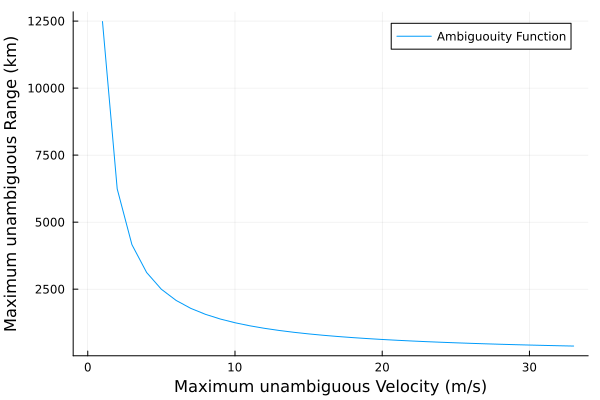

In [21]:
plot(v,r./1000, labels="Ambiguouity Function", xlabel="Maximum unambiguous Velocity (m/s)", ylabel="Maximum unambiguous Range (km)")